<font style='font-size:1.5em'>**🗓️ Week 10 – Applications I: text mining  <span style='color:#eaeaea'>\& network analysis</span>**</font>

<font style='font-size:1.2em'>DS105L – Data for Data Science</font>

**AUTHOR:**  Dr. [Jon Cardoso-Silva](https://www.lse.ac.uk/DSI/People/Jonathan-Cardoso-Silva)

**DEPARTMENT:** [LSE Data Science Institute](https://twitter.com/lsedatascience)

**DATE:** 24 March 2023


<div>
<img src="../../../figures/icons/DS105L_favicon.png" width="36"/>
</div>

---

# 📚 Learning Objectives

Today you will see an overview of the following python packages:

- [NLTK](https://www.nltk.org/)
- [spaCy](https://spacy.io/) and 
- [🤗 HuggingFace](https://huggingface.co/)

⚠️ Some chunks of this notebook might not make much sense if you were not in the lecture. Much of the code here is uncommented because I explained it in the lecture.

# ⚙️ Setup and Data Collection

Follow the ⚙️ setup instructions from [Week 05](https://lse-dsi.github.io/DS105/2023/weeks/week05/page.html#lecture-slides) if you want to replicate the code in this notebook.

## Import relevant packages

In [2]:
import os

import math

# I noticed that a few video titles used a different encoding
# To avoid a bunch of warnings, I'm going to ignore them
import warnings
warnings.filterwarnings("ignore")

#%config InlineBackend.figure_formats = ['svg']

import matplotlib.pyplot as plt
%matplotlib inline

## Google API Setup (for YouTube API)
import googleapiclient.discovery

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
from plotnine import *

## Google API setup

Setting up a few things as recommended by the [Google API documentation](https://developers.google.com/explorer-help/code-samples#python):


In [2]:
# Adapted from https://developers.google.com/explorer-help/code-samples#python
# Disable OAuthlib's HTTPS verification when running locally.
# *DO NOT* leave this option enabled in production. Do you want to know what "production" means? Ask your instructor.
os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

**Authenticating with Google**

In [3]:
### IMPORTANT ###

# Read my SECRET API key from youtube_api_key.txt (Read ⚙️ Setup section above)
# ⚠️ REMEMBER: NEVER SHARE THIS FILE WITH ANYONE ⚠️
my_api_key = open("youtube_api_key.txt", "r").read()

In [4]:
youtube_client = googleapiclient.discovery.build(serviceName="youtube", 
                                                 version="v3", 
                                                 developerKey=my_api_key)

## Getting data

In [5]:
from youtubecustom import get_video_categories, get_most_popular_videos, get_top_level_comments

selected_regions = ["GB"]

df_video_categories = pd.concat([get_video_categories(region_code, youtube_client) 
                                 for region_code in tqdm(selected_regions)])

df_video_categories.rename(columns={"id": "video_category_id"}, inplace=True)

df_videos = pd.concat([get_most_popular_videos(region_code, youtube_client, video_category_id, max_results=50) 
                       for region_code in tqdm(df_video_categories["region_code"].unique())
                       for video_category_id in df_video_categories\
                        .query("region_code == @region_code & assignable == True")["video_category_id"]])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

**Organising data types**

In [6]:
# Convert the published_at column to a datetime
df_videos["published_at"] = pd.to_datetime(df_videos["published_at"])

# Convert the duration column to a timedelta 
# There's a lot going on in the following line. To understand it fully, spend some time in the documentation
#  https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timedelta.html?highlight=timedelta#pandas.Timedelta
df_videos["duration"] = pd.to_timedelta(df_videos["duration"]).dt.total_seconds()

# Convert the view_count, like_count, favorite_count, and comment_count columns to integers
df_videos[["view_count", "like_count", "favorite_count", "comment_count"]] = df_videos[["view_count", "like_count", "favorite_count", "comment_count"]].astype(pd.Int64Dtype())

df_videos["region_code"] = df_videos["region_code"].astype("category")

**Merge video categories with video data**

In [7]:
df_videos = pd.merge(df_videos, df_video_categories, 
                     left_on=["region_code", "video_category_id"], 
                     right_on=["region_code", "video_category_id"], how="left")

**Check how the data looks like:**

In [8]:
index_cols      = ['region_code', 'channel_title', 'title', 'id']
col_aggregators = ['category_title']
value_col       = ['present']

selected_cols = index_cols + col_aggregators + value_col

df_pivotted = df_videos\
    .assign(present=1)[selected_cols]\
    .pivot_table(index=index_cols, columns=col_aggregators, fill_value=0, margins=True, aggfunc=np.sum)\
    .sort_values(('present',                  'All'), ascending=False)

df_pivotted

present  \
category_title                                                                                  Autos & Vehicles   
region_code channel_title        title                                              id                             
All                                                                                                           50   
GB          Mark Rober           Amazing Invention- This Drone Will Change Every... DOWDNBu9DkU                1   
            SidemenReacts        FUNNIEST TGF MOMENTS OF ALL  TIME!                 uAwZwltDtdg                0   
            Sidemen              SIDEMEN TRY NOT TO MOVE CHALLENGE                  7SUTGf4h6jE                0   
            Griffins on Demand   Not so fast #shorts                                iUG7haKtCVk                0   
...                                                                                                          ...   
            HUM TV               Tinkay Ka Sahara - Episode 26 [𝐂𝐂] - ( Sonya Hu... K0jk6i3jk6M                0   
            H3 Podcast           We Get Trashed For St. Paddy's Day - After Dark... dZyrcG7auic                0   
                                 Debating A TikTok Alpha Male - Off The Rails #65   _7pONVxRvDQ                0   
            Guinness Six Nations HIGHLIGHTS | Ireland v England | 2023 Guinness ... EsnWJq_Lbpk                0   
            Liv Swearingen (LIV) SHE’S THE VOICE OF MEGAN!!?                        9GvwjSL8hK8                0   

                                                                                                        \
category_title                                                                                  Comedy   
region_code channel_title        title                                              id                   
All                                                                                                 50   
GB          Mark Rober           Amazing Invention- This Drone Will Change Every... DOWDNBu9DkU      0   
            SidemenReacts        FUNNIEST TGF MOMENTS OF ALL  TIME!                 uAwZwltDtdg      1   
            Sidemen              SIDEMEN TRY NOT TO MOVE CHALLENGE                  7SUTGf4h6jE      1   
            Griffins on Demand   Not so fast #shorts                                iUG7haKtCVk      1   
...                                                                                                ...   
            HUM TV               Tinkay Ka Sahara - Episode 26 [𝐂𝐂] - ( Sonya Hu... K0jk6i3jk6M      0   
            H3 Podcast           We Get Trashed For St. Paddy's Day - After Dark... dZyrcG7auic      0   
                                 Debating A TikTok Alpha Male - Off The Rails #65   _7pONVxRvDQ      1   
            Guinness Six Nations HIGHLIGHTS | Ireland v England | 2023 Guinness ... EsnWJq_Lbpk      0   
            Liv Swearingen (LIV) SHE’S THE VOICE OF MEGAN!!?                        9GvwjSL8hK8      0   

                                                                                                               \
category_title                                                                                  Entertainment   
region_code channel_title        title                                              id                          
All                                                                                                        50   
GB          Mark Rober           Amazing Invention- This Drone Will Change Every... DOWDNBu9DkU             0   
            SidemenReacts        FUNNIEST TGF MOMENTS OF ALL  TIME!                 uAwZwltDtdg             1   
            Sidemen              SIDEMEN TRY NOT TO MOVE CHALLENGE                  7SUTGf4h6jE             1   
            Griffins on Demand   Not so fast #shorts                                iUG7haKtCVk             1   
...                                                                                        

In [9]:
df_videos.to_pickle("data/df_videos.pkl")

**Collect top-level comments for each video**

In [10]:
response = youtube_client.commentThreads()\
    .list(part='id,replies,snippet', videoId='K0jk6i3jk6M', maxResults=100, textFormat='plainText')\
    .execute()

In [11]:
# Collect and concatenate the top-level comments for each video

def collect_comments(video_id, youtube_client):
    df_comments, _ = get_top_level_comments(video_id, youtube_client)
    return df_comments

df_comments = pd.concat([collect_comments(video_id, youtube_client) for video_id in tqdm(df_videos["id"].unique())])

  0%|          | 0/527 [00:00<?, ?it/s]

For replicability, we will save the data we collected to a file. This way, we can use it later without having to collect it again.

In [12]:
df_comments.to_pickle("data/df_comments.pkl")

# Act 01: Looking at the data

<details><summary>Click here to see code to load the data</summary>

\# If you just want to load the data, run this cell

```python
import pickle

with open('data/df_videos.pkl', 'rb') as f:
    df_videos = pickle.load(f)

with open('data/df_comments.pkl', 'rb') as f:
    df_comments = pickle.load(f)
```

</details>

In [2]:
df_comments.head()

,comment_id,like_count,comment_text,replies.comments,video_id
0,UgwKnKT1S_C1Uyqbt394AaABAg,0,Ethan looked like he enjoyed all of them chall...,NaN,7SUTGf4h6jE
1,UgwuC1XZekXtRoPAt4d4AaABAg,0,Wish KSI would piss on me,"[{'kind': 'youtube#comment', 'etag': 'lohipHMe...",7SUTGf4h6jE
2,UgwvTEFqQ_wU1wAA0cN4AaABAg,2,I like it when Simon presents ❤️,NaN,7SUTGf4h6jE
3,UgxIYuPjiNcibOcM69R4AaABAg,0,That's lizard wasn't having none of it.,NaN,7SUTGf4h6jE
4,UgxcWlWzxh5IN2l0otJ4AaABAg,0,this must be illegal xD,NaN,7SUTGf4h6jE


How many comments do we have?

In [3]:
df_comments.shape

(49193, 5)

How many unique videos are represented in this data frame?

In [15]:
df_comments['video_id'].nunique()

516

I collected only the top-level comments, and only the first 100 comments for each video. 

**Do all videos have 100 comments?**

<Axes: >

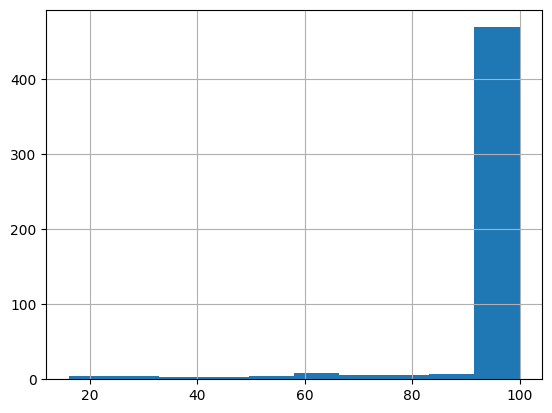

In [16]:
df_comments.groupby(['video_id']).size().sort_values(ascending=False).hist()

**What are the less commented videos?**


In [17]:
df_comments.groupby(['video_id']).size().sort_values(ascending=True).head()

video_id
MsuUGj6KeVw    16
eRAFwWs1TJw    21
6T9tfFkr0P4    22
ju4jlpMiiOQ    23
2pif5Bd3d08    25
dtype: int64

In [18]:
df_videos.query('id == "MsuUGj6KeVw"').set_index(['title'])

,id,published_at,channel_title,description,duration,view_count,like_count,favorite_count,comment_count,region_code,video_category_id,category_title,assignable
title,,,,,,,,,,,,,
ChrisMD's Sibling Obsession,MsuUGj6KeVw,2023-03-19 08:00:07+00:00,The Fellas,Watch the FULL Podcast Clips HERE: https://www...,23.0,217243,7062,0,69,GB,23,Comedy,True


# Act 02: Text mining using pure Python

In [2]:
# Let's get all unique words that appear in all comments

# I will show different variations in the lecture

# https://www.w3schools.com/python/python_regex.asp
import re

def get_words(text):
    """Returns a list of words (including emojis) from a string"""

    # simple regex to match words
    # pattern = re.compile(r'\w+')

    # use the re module to match emojis
    # pattern = re.compile(r'[\w]+|[\U0001F300-\U0001F64F\U0001F680-\U0001F6FF]+')

    # Attempt 02
    pattern = re.compile(r'[\w]+|[\U0001F300-\U0001F64F\U0001F680-\U0001F6FF](?:\d[\U0001F3FB-\U0001F3FF])?')

    # return a list of all matches
    return pattern.findall(text)

df_comments['words'] = df_comments['comment_text'].apply(get_words)
df_comments[['comment_text', 'words']].set_index(['words']).head()

,comment_text
words,
"[Ethan, looked, like, he, enjoyed, all, of, them, challenges, haha]",Ethan looked like he enjoyed all of them chall...
"[Wish, KSI, would, piss, on, me]",Wish KSI would piss on me
"[I, like, it, when, Simon, presents]",I like it when Simon presents ❤️
"[That, s, lizard, wasn, t, having, none, of, it]",That's lizard wasn't having none of it.
"[this, must, be, illegal, xD]",this must be illegal xD


## Using the `regex` package

In [4]:
import regex

def get_words(text):
    """Returns a list of words (including emojis) from a string"""

    # use a regex pattern that matches alphanumeric characters, underscores, and emojis
    pattern = regex.compile(r'[\p{L}\p{M}\p{N}_]+|[\p{So}\p{Sk}](?:\p{EMod})?')

    # return a list of all matches
    return pattern.findall(text)

df_comments['words'] = df_comments['comment_text'].apply(get_words)

df_comments[['comment_text', 'words']].set_index(['words']).tail()

,comment_text
words,
[HA],HA
"[Which, app, do, you, use]",Which app do you use?
"[Did, you, just, draw, the, bangchan, in, last]",Did you just draw the bangchan in last ?
"[Kooleen, do, you, wanna, tell, us, something]",Kooleen do you wanna tell us something
"[Didn, t, know, she, liked, furries, 👁, ️, 👄, 👁, ️]",Didn't know she liked furries👁️👄👁️


In [8]:
# Remember 💣 the explode() function?
df_comments['words'].explode()

0       Ethan
0      looked
0        like
0          he
0     enjoyed
       ...   
99          👁
99          ️
99          👄
99          👁
99          ️
Name: words, Length: 767937, dtype: object

**How many unique words are there in the comments?**

In [9]:
df_comments['words'].explode().nunique()

58178

What is the ratio of unique words to total words?

In [10]:
df_comments['words'].explode().nunique()/df_comments['words'].explode().count()

0.07576454102794841

**What are the most common words?**

In [11]:
df_comments['words'].explode().value_counts().head(10)

the    23550
I      15109
a      14712
to     14567
and    13171
is     10411
you     9855
of      8764
it      8352
in      7562
Name: words, dtype: int64

How many words do comments have on average?

In [12]:
df_comments['words'].apply(lambda x: len(x)).describe()

count    49193.000000
mean        15.609518
std         29.616597
min          0.000000
25%          5.000000
50%         10.000000
75%         17.000000
max       1888.000000
Name: words, dtype: float64

In [5]:
selected_range = (
    (df_comments['words'].apply(lambda x: len(x)) <= 20) & 
    (df_comments['words'].apply(lambda x: len(x)) > 0))

df_comments[selected_range]['words'].apply(lambda x: len(x)).describe()

count    39434.000000
mean         8.492697
std          5.035115
min          1.000000
25%          4.000000
50%          8.000000
75%         12.000000
max         20.000000
Name: words, dtype: float64

In [5]:
print(f"With this rule, I still keep {df_comments[selected_range].shape[0]/df_comments.shape[0]:.2%} of the comments")

With this rule, I still keep 80.16% of the comments


In [5]:
df_comments = df_comments[selected_range].drop(columns=['words']).copy()

How should we go about cleaning the comments?

# Act 03: NLTK

Let's take our first steps with Natural Language Processing (NLP) using the [Natural Language Toolkit (NLTK)](https://www.nltk.org/).

One of the first things we might want to do is to identify the most common words in our data. We could do this naively by counting the number of times each word appears in the data. However, this approach has a few problems:

- It will count words that are not very informative, such as "the", "a", "and", etc.
- It will count words that are very common in the language, but not necessarily in the context of our data. For example, the word "cat" is very common in English, but might not be very informative if we were analysing cat-related channels only.

To solve these problems, the NLP community has developed a number of standards for how to preprocess text data. Let's learn about some of them.

## Tokenization + removal of stop words

⚠️ Some chunks of this notebook might not make much sense if you were not in the lecture. Much of the code here is uncommented because I explained it in the lecture.

In [6]:
import nltk
import string
from nltk.tokenize import word_tokenize

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
#nltk.download()

In [7]:
stop_words = set(nltk.corpus.stopwords.words('english'))
len(stop_words)

179

In [ ]:
stop_words

Therefore, we might need to do a bit more pre-processing on the text before we can remove stop words. Let's see how we can do that.

In [8]:
from nltk.tokenize.casual import TweetTokenizer
t = TweetTokenizer()

def preprocess_text(text):
    # convert the text to lowercase
    text = text.lower()
    # remove punctuation marks
    text = text.translate(str.maketrans('', '', string.punctuation))
    # tokenize the text
    tokens = TweetTokenizer().tokenize(text)
    # remove stopwords
    stop_words = set(nltk.corpus.stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]

    return filtered_tokens

In [9]:
# The first time you run the code below, you will get an error
# This is because you need to install additional data
# http://www.nltk.org/nltk_data/

# nltk.download('webtext')
# nltk.download('nps_chat')
# nltk.download('punkt')

df_comments['tokens'] = df_comments['comment_text'].apply(preprocess_text)
df_comments.head(20)

,comment_id,like_count,comment_text,replies.comments,video_id,tokens
0,UgwKnKT1S_C1Uyqbt394AaABAg,0,Ethan looked like he enjoyed all of them chall...,NaN,7SUTGf4h6jE,"[ethan, looked, like, enjoyed, challenges, haha]"
1,UgwuC1XZekXtRoPAt4d4AaABAg,0,Wish KSI would piss on me,"[{'kind': 'youtube#comment', 'etag': 'lohipHMe...",7SUTGf4h6jE,"[wish, ksi, would, piss]"
2,UgwvTEFqQ_wU1wAA0cN4AaABAg,2,I like it when Simon presents ❤️,NaN,7SUTGf4h6jE,"[like, simon, presents, ❤, ️]"
3,UgxIYuPjiNcibOcM69R4AaABAg,0,That's lizard wasn't having none of it.,NaN,7SUTGf4h6jE,"[thats, lizard, wasnt, none]"
4,UgxcWlWzxh5IN2l0otJ4AaABAg,0,this must be illegal xD,NaN,7SUTGf4h6jE,"[must, illegal, xd]"
5,UgxZwfJND8hpc_toY0h4AaABAg,0,KSI afraid of appearing in more of sidemen vid...,NaN,7SUTGf4h6jE,"[ksi, afraid, appearing, sidemen, videos, 😂, 😂]"
6,Ugyp46AUk6QiKQn-Wpl4AaABAg,0,24:00 that's jj big brain moment there,NaN,7SUTGf4h6jE,"[2400, thats, jj, big, brain, moment]"
7,UgwFdbn6cmxGeBrRc1V4AaABAg,0,I fel l from my chair...,NaN,7SUTGf4h6jE,"[fel, l, chair]"
9,Ugyu7gQSwsb0fDpJksp4AaABAg,0,THATS MAD BRAH,NaN,7SUTGf4h6jE,"[thats, mad, brah]"
10,UgwZ_ShOgImPQ3mDssx4AaABAg,1,The grip reaper dance was the only funny thing...,NaN,7SUTGf4h6jE,"[grip, reaper, dance, funny, thing, video, lma..."


**What if I wanted to split sentences?**

In [ ]:
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
print('\n-----\n'.join(sent_detector.tokenize(df_comments['comment_text'].iloc[1000].strip())))

Omg meme time
We haven't had it in ages now


## WordClouds

In [33]:
print(f"Number of unique words: {df_comments['comment_text'].apply(get_words).explode().nunique()}")

Number of unique words: 37496


In [19]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

from PIL import Image

def create_wordcloud(text):

    mask = np.array(Image.open('figures/Red-Heart-vector-2731436.svg.png'))
    mask_colors = ImageColorGenerator(mask)

    wc = WordCloud(
                background_color="white",
                max_words=2000, max_font_size=150,
                random_state=42, 
                mask=mask, width=mask.shape[1]*10,
                height=mask.shape[0]*10, color_func=mask_colors
                )
    wc.generate(text)

    # plot the wordcloud
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.show()

**Using our tokens:**

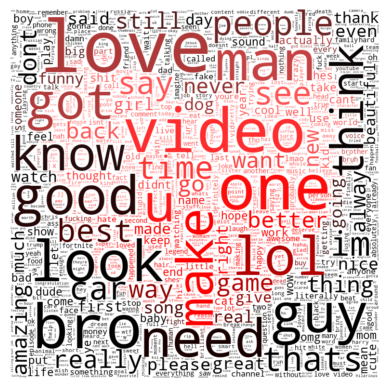

In [20]:
create_wordcloud(" ".join(df_comments['tokens'].apply(lambda x: ' '.join(x))))

**Compare it with the version without filters:**

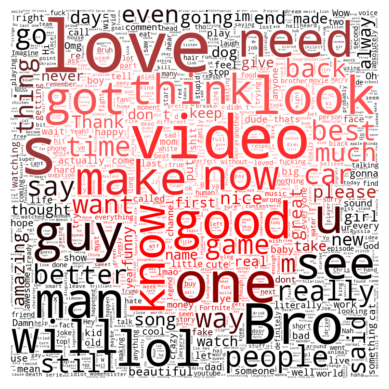

In [21]:
create_wordcloud(" ".join(df_comments['comment_text']))

See more wordcloud tutorials here: https://towardsdatascience.com/generate-meaningful-word-clouds-in-python-5b85f5668eeb

**There's more to the world of text pre-processing though...**

In [22]:
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

# download the necessary resources for NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# initialize the lemmatizer and stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# define a function to tokenize, lemmatize, and stem the comments
def preprocess_text(text):
    # convert the text to lowercase
    text = text.lower()
    # remove punctuation marks
    text = text.translate(str.maketrans('', '', string.punctuation))
    # tokenize the text
    tokens = word_tokenize(text)
    # remove stopwords
    stop_words = set(nltk.corpus.stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # lemmatize each token
    lemmas = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    # stem each token
    stems = [stemmer.stem(lemma) for lemma in lemmas]
    # join the stems into a single string
    processed_text = ' '.join(stems)
    return processed_text

# apply the function to the comment_text column
df_comments['processed_text'] = df_comments['comment_text'].apply(preprocess_text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


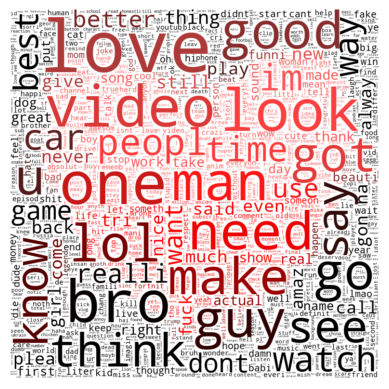

In [23]:
create_wordcloud(" ".join(df_comments['processed_text']))

# Act 03: spaCy

In [42]:
#!python3 -m spacy download en_core_web_sm

In [6]:
import spacy

nlp = spacy.load('en_core_web_sm')

**From spaCy [docs](https://spacy.io/usage/spacy-101/):**

- **Text**: The original word text.
- **Lemma**: The base form of the word.
- **POS**: The simple UPOS part-of-speech tag.
- **Tag**: The detailed part-of-speech tag.
- **Dep**: Syntactic dependency, i.e. the relation between tokens.
- **Shape**: The word shape – capitalization, punctuation, digits.
- **is alpha**: Is the token an alpha character?
- **is stop**: Is the token part of a stop list, i.e. the most common words of the language?

In [7]:
def get_nlp_elements(doc):
    df = pd.DataFrame([[token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
                            token.shape_, token.is_alpha, token.is_stop] for token in doc], 
                            columns=['text', 'lemma', 'pos', 'tag', 'dep', 'shape', 'is_alpha', 'is_stop'])
    return df

pd.concat([get_nlp_elements(doc) for doc in nlp.pipe(df_comments['comment_text'].iloc[0:10])])

,text,lemma,pos,tag,dep,shape,is_alpha,is_stop
0,Ethan,Ethan,PROPN,NNP,nsubj,Xxxxx,True,False
1,looked,look,VERB,VBD,ROOT,xxxx,True,False
2,like,like,SCONJ,IN,mark,xxxx,True,False
3,he,he,PRON,PRP,nsubj,xx,True,True
4,enjoyed,enjoy,VERB,VBD,advcl,xxxx,True,False
...,...,...,...,...,...,...,...,...
22,it,it,PRON,PRP,dobj,xx,True,True
23,.,.,PUNCT,.,punct,.,False,False
0,THATS,thats,ADJ,JJ,amod,XXXX,True,False
1,MAD,MAD,PROPN,NNP,compound,XXX,True,False


**Dependencies visualisation**

In [45]:
df_comments['comment_text'].iloc[0]

'Ethan looked like he enjoyed all of them challenges haha'

In [47]:
from spacy import displacy

doc = nlp(df_comments['comment_text'].iloc[0])

displacy.serve(doc, style="dep")


Using the 'dep' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


**Are there any recognisable entities here?**

In [54]:
doc = nlp(df_comments['comment_text'].iloc[4000])

displacy.serve(doc, style="ent")


Using the 'ent' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


**See other visualisers: https://spacy.io/usage/visualizers**

### Document Term Frequency

In [9]:
df_comments['spacy_tokens'] = df_comments['comment_text'].apply(lambda x: nlp(x.lower()))

In [71]:
df_comments.head()

,comment_id,like_count,comment_text,replies.comments,video_id,tokens,processed_text,spacy_tokens
0,UgwKnKT1S_C1Uyqbt394AaABAg,0,Ethan looked like he enjoyed all of them chall...,NaN,7SUTGf4h6jE,"[ethan, looked, like, enjoyed, challenges, haha]",ethan look like enjoy challeng haha,"(ethan, looked, like, he, enjoyed, all, of, th..."
1,UgwuC1XZekXtRoPAt4d4AaABAg,0,Wish KSI would piss on me,"[{'kind': 'youtube#comment', 'etag': 'lohipHMe...",7SUTGf4h6jE,"[wish, ksi, would, piss]",wish ksi would piss,"(wish, ksi, would, piss, on, me)"
2,UgwvTEFqQ_wU1wAA0cN4AaABAg,2,I like it when Simon presents ❤️,NaN,7SUTGf4h6jE,"[like, simon, presents, ❤, ️]",like simon present ❤️,"(i, like, it, when, simon, presents, ❤, ️)"
3,UgxIYuPjiNcibOcM69R4AaABAg,0,That's lizard wasn't having none of it.,NaN,7SUTGf4h6jE,"[thats, lizard, wasnt, none]",that lizard wasnt none,"(that, 's, lizard, was, n't, having, none, of,..."
4,UgxcWlWzxh5IN2l0otJ4AaABAg,0,this must be illegal xD,NaN,7SUTGf4h6jE,"[must, illegal, xd]",must illeg xd,"(this, must, be, illegal, xd)"


In [10]:
corpus = [str(row['spacy_tokens']) for idx, row in df_comments.iterrows()]

**A Bag of words**

💡 There is a new concept here called "ngrams"

In [17]:
# import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#instantiate a CountVectorizer object
# utilize the new STOP_WORDS list
cv = CountVectorizer(stop_words=list(nlp.Defaults.stop_words), ngram_range=(1, 1))

# fit transform our text and create a dataframe with the result
X = cv.fit_transform(corpus)
X = X.toarray()


bow = pd.DataFrame(X, columns = cv.get_feature_names_out())
bow.index = df_comments['comment_text']

In [18]:
bow.iloc[0:10, -15:-1]

,𝕐𝕠𝕦,𝕒𝕣𝕖,𝕚𝕥,𝕜𝕖𝕖𝕡,𝕝𝕦𝕜𝕖,𝕟𝕠𝕥,𝕦𝕡,𝙃𝙄𝙂𝙃,𝙃𝙚𝙡𝙡𝙤,𝙏𝙝𝙚,𝙗𝙞𝙧𝙙,𝙘𝙧𝙞𝙢𝙞𝙣𝙖𝙡,𝙙𝙚𝙚𝙥,𝙞𝙨
comment_text,,,,,,,,,,,,,,
Ethan looked like he enjoyed all of them challenges haha,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Wish KSI would piss on me,0,0,0,0,0,0,0,0,0,0,0,0,0,0
I like it when Simon presents ❤️,0,0,0,0,0,0,0,0,0,0,0,0,0,0
That's lizard wasn't having none of it.,0,0,0,0,0,0,0,0,0,0,0,0,0,0
this must be illegal xD,0,0,0,0,0,0,0,0,0,0,0,0,0,0
KSI afraid of appearing in more of sidemen videos 😂😂,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24:00 that's jj big brain moment there,0,0,0,0,0,0,0,0,0,0,0,0,0,0
I fel l from my chair...,0,0,0,0,0,0,0,0,0,0,0,0,0,0
This was the craziest sidemen Sunday. Throughout the whole video i was laughing but the end i never would have imagined it.,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**What are the top expressions?**

In [19]:
bow.sum(axis=0).sort_values(ascending=False).head(15).index

Index(['like', 'love', 'don', 'good', 'people', 'know', 'video', 'time', 'man',
       'think', 'got', 'bro', 'way', 'lol', 'need'],
      dtype='object')

**Statistics per category**

In [20]:
def get_is_comment_in_video_category(selected_category):

    unique_video_ids = df_comments[['video_id']].drop_duplicates()

    all_videos_in_category = df_videos[df_videos['category_title'] == selected_category]['id'].values.tolist()

    unique_video_ids['video_category'] = [selected_category if video_id in all_videos_in_category else 'Other'
                                        for video_id in unique_video_ids['video_id']]

    return pd.merge(df_comments[['video_id']], unique_video_ids)['video_category'].values

In [21]:
selected_category = 'Film & Animation' 

bow['video_category'] = get_is_comment_in_video_category(selected_category) 

In [22]:
bow['video_category'].value_counts()

Other               44407
Film & Animation     4786
Name: video_category, dtype: int64

In [1]:
# This might throw an out of memory error: 
# Can you guess why?

# bow.groupby(['video_category']).apply(lambda x: pd.Series({'top': x.sum().sort_values(ascending=False).head(5).index.values}))

**Most common words in Films & Annimation?**

In [34]:
bow[bow['video_category'] == selected_category].drop(columns=['video_category']).sum(axis=0).sort_values(ascending=False).head(15)

perfect    468
gotta      457
like       367
love       212
don        161
got        148
man        127
movie      124
know       119
people     118
good       116
time       110
bro        110
said       106
video       99
dtype: int64

## Act 04: 🤗 Hugging Face

Let's explore the UI together